# Speed Prediction

In this project, we will use weather data to predict average speed.

- we will use weather data from openweathermap.org which provides temperature, wind, humidity, and weather conditions

- This notebook will be running on Google Colab

# Install and import dependencies

In [1]:
!pip install pactools

     |████████████████████████████████| 92kB 6.1MB/s 
     |████████████████████████████████| 6.8MB 17.1MB/s 


In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from pactools.grid_search import GridSearchCVProgressBar
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Preprocess

## Asign Holiday to the table

In [4]:
def hour_modify(x: datetime):
    Early_Morning = [4,5,6,7]
    Morning = [8,9,10,11]
    Afternoon = [12,13,14,15]
    Evening = [16,17,18,19]
    Night = [20,21,22,23]
    Late_Night = [0,1,2,3]

    
    if x.hour in Early_Morning:
        return 'Early_Morning'
    elif x.hour in Morning:
        return 'Morning'
    elif x.hour in Afternoon:
        return 'Afternoon'
    elif x.hour in Evening:
        return 'Evening'
    elif x.hour in Night:
        return 'Night'
    else:
        return 'Late_Night'

def add_holiday_and_weekend(df: pd.DataFrame) -> pd.DataFrame:
    """
    Add holiday and weekend to the dataset
    """
    new_df = df.copy()
    new_df['IsWeekend'] = new_df['date'].apply(lambda x:0 if x.weekday() in [0,1,2,3,4] else 1)
    new_df['IsHoliday']=new_df['date'].apply(lambda x:1 if (x.date().strftime('%Y-%m-%d') in [
           '2017-01-02','2017-01-28','2017-01-30','2017-01-31','2017-04-04',
           '2017-04-14','2017-04-15','2017-04-17','2017-05-01','2017-05-03',
           '2017-05-30','2017-07-01','2017-10-02','2017-10-05','2017-10-28',
           '2017-12-25','2017-12-26',
           '2018-01-01','2018-02-16','2018-02-17','2018-02-19','2018-03-30',
           '2018-03-31','2018-04-02','2018-04-05','2018-05-01','2018-05-22',
           '2018-06-18','2018-07-02','2018-09-25','2018-10-01','2018-10-17',
           '2018-12-25','2018-12-26'
           ])
           or(x.weekday() in[6]) else 0)
    return new_df

I am using google drive to store all the data including the weather data. So please change this line to the your file paths.

In [5]:
# change following two lines to your paths
train = pd.read_csv('/content/drive/MyDrive/courses/HKUST/MSBD5001/project/data/individual project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/courses/HKUST/MSBD5001/project/data/individual project/test.csv')

train = train.drop('id', axis=1)
train['date'] = pd.to_datetime(train['date'])
train = add_holiday_and_weekend(train)
train['hour_modify']=train['date'].apply(hour_modify)

train

,date,speed,IsWeekend,IsHoliday,hour_modify
0,2017-01-01 00:00:00,43.002930,1,1,Late_Night
1,2017-01-01 01:00:00,46.118696,1,1,Late_Night
2,2017-01-01 02:00:00,44.294158,1,1,Late_Night
3,2017-01-01 03:00:00,41.067468,1,1,Late_Night
4,2017-01-01 04:00:00,46.448653,1,1,Early_Morning
...,...,...,...,...,...
14001,2018-12-31 12:00:00,19.865269,0,0,Afternoon
14002,2018-12-31 15:00:00,17.820375,0,0,Afternoon
14003,2018-12-31 16:00:00,12.501851,0,0,Evening
14004,2018-12-31 18:00:00,15.979319,0,0,Evening


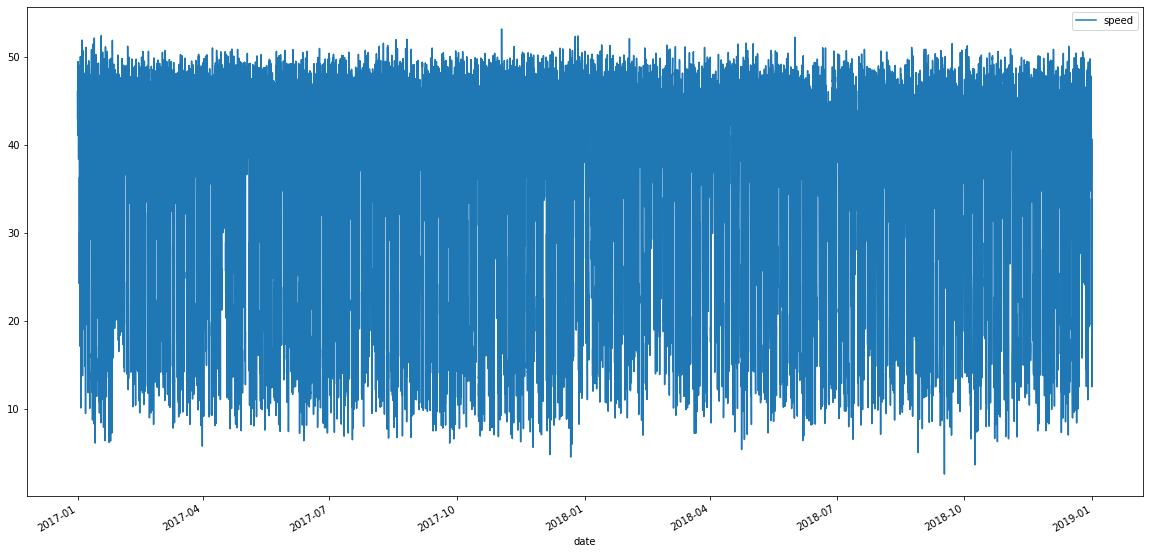

In [6]:
train.plot(x='date', y='speed', figsize=(20, 10))

## Merge weather

### Pre-process weather data

In [7]:
from datetime import datetime
def k_to_c(x):
    return x - 273.15

In [8]:
# Change this path to yours
weather = pd.read_csv("/content/drive/MyDrive/courses/HKUST/MSBD5001/project/data/individual project/hongkong_weather_1970-2020.csv")
weather['dt_iso'] = weather['dt_iso'].apply(lambda x: x.replace('UTC', ''))
weather['date'] = pd.to_datetime(weather['dt_iso']).dt.tz_convert("Asia/Hong_Kong").dt.tz_localize(None)

# Transform unit
weather['temp'] = weather['temp'].apply(k_to_c)
weather['feels_like'] = weather['feels_like'].apply(k_to_c)
weather['temp_min'] = weather['temp_min'].apply(k_to_c)
weather['temp_max'] = weather['temp_max'].apply(k_to_c)

weather = weather.drop(["dt_iso", "dt", "weather_icon", "rain_1h", "rain_3h", "snow_1h", "snow_3h", "sea_level", "grnd_level", "timezone", "lat", "lon"], axis=1)
mask = (weather['date'] >= datetime(2017,1,1)) & (weather['date'] <= datetime(2019, 1, 1))
weather = weather.loc[mask]
weather

,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,date
334235,Hong Kong,18.04,18.64,16.5,20.000,1022,83,1.5,99,7,800,Clear,sky is clear,2017-01-01 00:00:00
334236,Hong Kong,17.92,18.22,16.0,20.000,1022,76,1.2,76,15,801,Clouds,few clouds,2017-01-01 01:00:00
334237,Hong Kong,17.90,18.19,16.0,20.000,1022,76,1.2,76,20,801,Clouds,few clouds,2017-01-01 02:00:00
334238,Hong Kong,17.79,18.05,16.0,19.526,1022,76,1.2,76,29,802,Clouds,scattered clouds,2017-01-01 03:00:00
334239,Hong Kong,17.75,17.23,16.0,19.468,1021,75,2.2,53,19,801,Clouds,few clouds,2017-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351755,Hong Kong,10.91,7.88,9.0,13.273,1019,65,2.6,347,58,803,Clouds,broken clouds,2018-12-31 20:00:00
351756,Hong Kong,10.68,7.61,9.0,13.255,1019,65,2.6,347,56,803,Clouds,broken clouds,2018-12-31 21:00:00
351757,Hong Kong,10.52,7.51,9.0,13.279,1019,67,2.6,354,52,803,Clouds,broken clouds,2018-12-31 22:00:00
351758,Hong Kong,10.32,7.27,9.0,13.289,1019,67,2.6,354,36,802,Clouds,scattered clouds,2018-12-31 23:00:00


### Merge

In [9]:
def merge_weather(df: pd.DataFrame, weather: pd.DataFrame) -> pd.DataFrame:
    '''
    Merge weather with data.
    '''
    new_df = df.copy()
    new_weather = weather.copy()

    new_df['tmp_date'] = new_df['date']
    new_weather['tmp_date'] = new_weather['date']

    new_training_data = new_df.merge(new_weather, on='tmp_date', how='left')
    new_training_data = new_training_data.drop(['tmp_date', 'date_y'], axis=1)
    new_training_data = new_training_data.rename(columns={'date_x': 'date'})
    return new_training_data


In [10]:
new_training_data = merge_weather(train, weather)

new_training_data

,date,speed,IsWeekend,IsHoliday,hour_modify,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description
0,2017-01-01 00:00:00,43.002930,1,1,Late_Night,Hong Kong,18.04,18.64,16.50,20.000,1022,83,1.5,99,7,800,Clear,sky is clear
1,2017-01-01 01:00:00,46.118696,1,1,Late_Night,Hong Kong,17.92,18.22,16.00,20.000,1022,76,1.2,76,15,801,Clouds,few clouds
2,2017-01-01 02:00:00,44.294158,1,1,Late_Night,Hong Kong,17.90,18.19,16.00,20.000,1022,76,1.2,76,20,801,Clouds,few clouds
3,2017-01-01 03:00:00,41.067468,1,1,Late_Night,Hong Kong,17.79,18.05,16.00,19.526,1022,76,1.2,76,29,802,Clouds,scattered clouds
4,2017-01-01 04:00:00,46.448653,1,1,Early_Morning,Hong Kong,17.75,17.23,16.00,19.468,1021,75,2.2,53,19,801,Clouds,few clouds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14004,2018-12-31 12:00:00,19.865269,0,0,Afternoon,Hong Kong,11.71,7.88,10.70,13.500,1028,61,3.7,341,72,803,Clouds,broken clouds
14005,2018-12-31 15:00:00,17.820375,0,0,Afternoon,Hong Kong,12.36,9.75,10.56,15.560,1016,56,1.8,342,44,802,Clouds,scattered clouds
14006,2018-12-31 16:00:00,12.501851,0,0,Evening,Hong Kong,12.06,8.93,10.00,15.054,1016,58,2.6,349,39,802,Clouds,scattered clouds
14007,2018-12-31 18:00:00,15.979319,0,0,Evening,Hong Kong,11.70,8.51,10.00,13.890,1017,58,2.6,349,48,802,Clouds,scattered clouds


## Plot data

### Univariate analysis

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


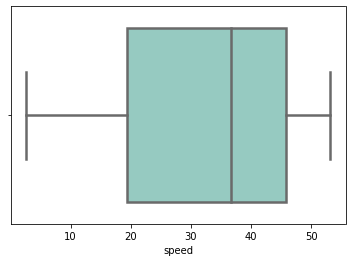

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot('speed',data=new_training_data,orient='h',palette="Set3",linewidth=2.5)
plt.show()

### Traffic speed across months.

In [12]:
data_plot = new_training_data
data_plot['month'] = data_plot['date'].dt.month
data_plot

,date,speed,IsWeekend,IsHoliday,hour_modify,city_name,temp,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,weather_main,weather_description,month
0,2017-01-01 00:00:00,43.002930,1,1,Late_Night,Hong Kong,18.04,18.64,16.50,20.000,1022,83,1.5,99,7,800,Clear,sky is clear,1
1,2017-01-01 01:00:00,46.118696,1,1,Late_Night,Hong Kong,17.92,18.22,16.00,20.000,1022,76,1.2,76,15,801,Clouds,few clouds,1
2,2017-01-01 02:00:00,44.294158,1,1,Late_Night,Hong Kong,17.90,18.19,16.00,20.000,1022,76,1.2,76,20,801,Clouds,few clouds,1
3,2017-01-01 03:00:00,41.067468,1,1,Late_Night,Hong Kong,17.79,18.05,16.00,19.526,1022,76,1.2,76,29,802,Clouds,scattered clouds,1
4,2017-01-01 04:00:00,46.448653,1,1,Early_Morning,Hong Kong,17.75,17.23,16.00,19.468,1021,75,2.2,53,19,801,Clouds,few clouds,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14004,2018-12-31 12:00:00,19.865269,0,0,Afternoon,Hong Kong,11.71,7.88,10.70,13.500,1028,61,3.7,341,72,803,Clouds,broken clouds,12
14005,2018-12-31 15:00:00,17.820375,0,0,Afternoon,Hong Kong,12.36,9.75,10.56,15.560,1016,56,1.8,342,44,802,Clouds,scattered clouds,12
14006,2018-12-31 16:00:00,12.501851,0,0,Evening,Hong Kong,12.06,8.93,10.00,15.054,1016,58,2.6,349,39,802,Clouds,scattered clouds,12
14007,2018-12-31 18:00:00,15.979319,0,0,Evening,Hong Kong,11.70,8.51,10.00,13.890,1017,58,2.6,349,48,802,Clouds,scattered clouds,12


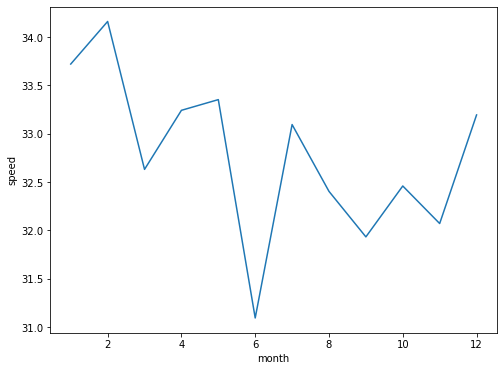

In [13]:
tmp_data=new_training_data.groupby('month').aggregate({'speed':'mean'})
plt.figure(figsize=(8,6))
sns.lineplot(x=tmp_data.index,y=tmp_data.speed,data=tmp_data,palette="Set2")
plt.show()

### Count on different hour stage.

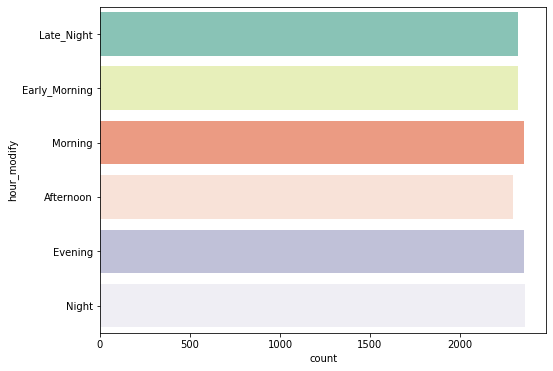

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(y='hour_modify',data=new_training_data,palette=["#7fcdbb","#edf8b1","#fc9272","#fee0d2","#bcbddc","#efedf5"])
plt.show()

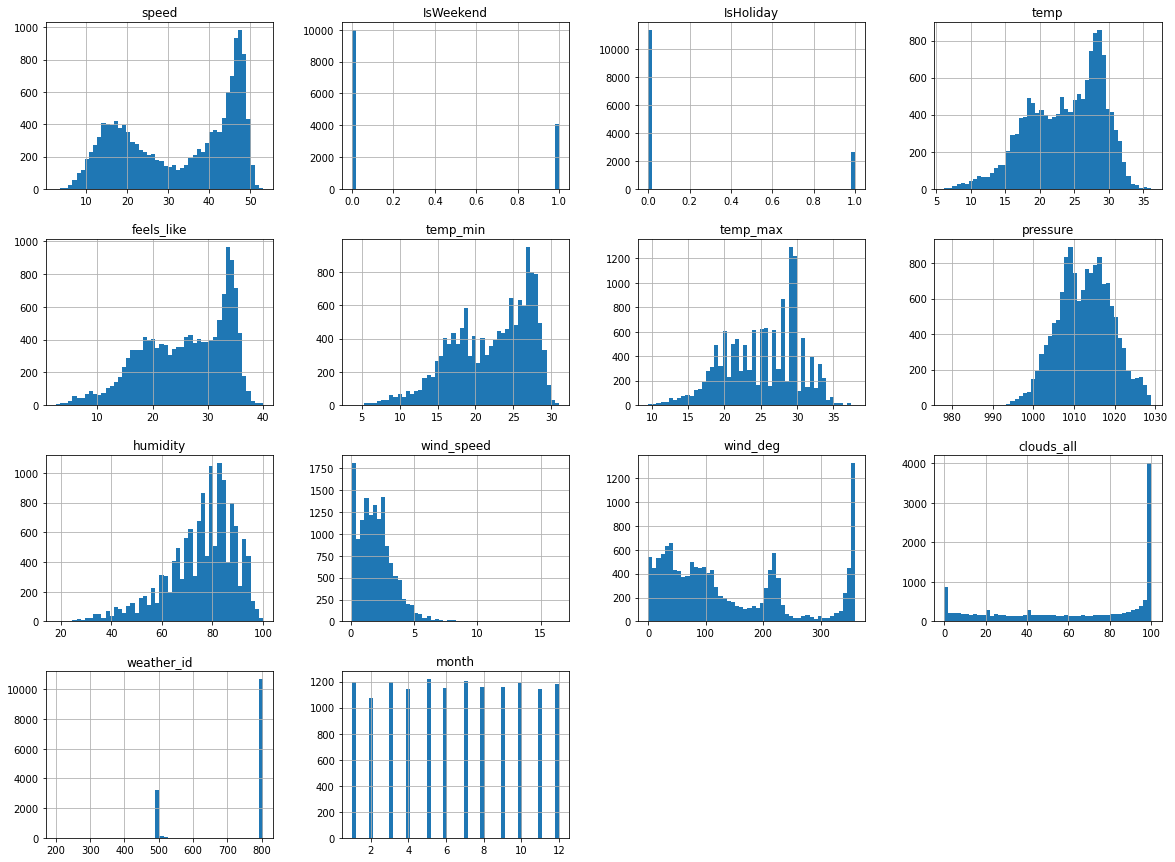

In [15]:
new_training_data.hist(bins=50,figsize=(20,15))
plt.show()

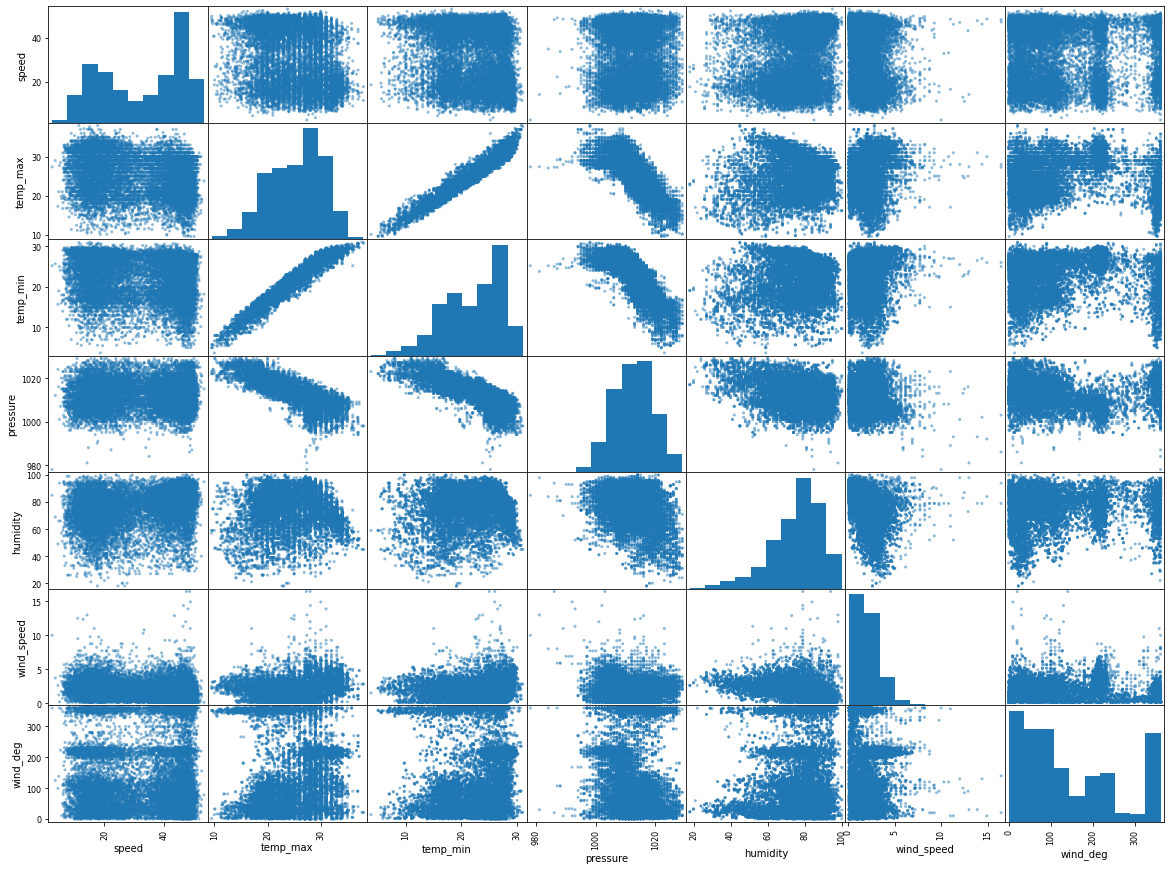

In [16]:
num_vars=['speed','temp_max','temp_min','pressure','humidity','wind_speed','wind_deg']
from pandas.plotting import scatter_matrix
scatter_matrix(new_training_data[num_vars],figsize=(20,15))
plt.show()

<Figure size 720x576 with 0 Axes>

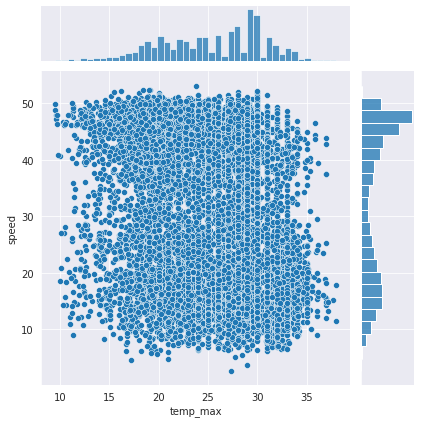

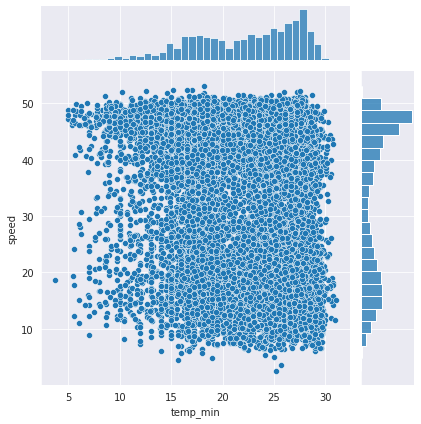

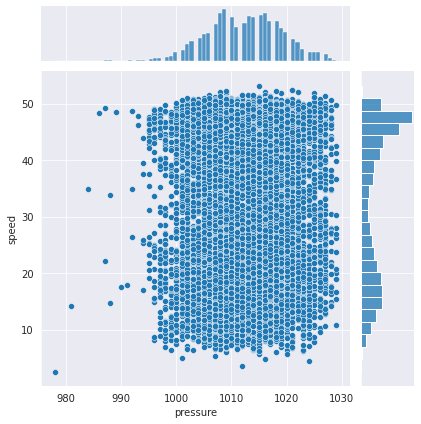

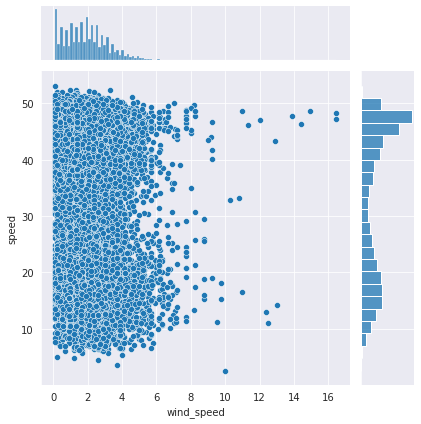

In [17]:
plt.figure(figsize=(10,8))

sns.set_style('darkgrid')
sns.jointplot(y='speed',x='temp_max',data =new_training_data)


sns.set_style('darkgrid')
sns.jointplot(y='speed',x='temp_min',data =new_training_data)


sns.set_style('darkgrid')
sns.jointplot(y='speed',x='pressure',data =new_training_data)


sns.set_style('darkgrid')
sns.jointplot(y='speed',x='wind_speed',data =new_training_data)

plt.show()

# Train

In [18]:
new_training_data.columns

Index(['date', 'speed', 'IsWeekend', 'IsHoliday', 'hour_modify', 'city_name',
       'temp', 'feels_like', 'temp_min', 'temp_max', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds_all', 'weather_id', 'weather_main',
       'weather_description', 'month'],
      dtype='object')

In [34]:
target=['speed']
cat_vars=['IsWeekend','IsHoliday','hour_modify', 'weather_main']
num_vars=['temp', 'pressure', 'wind_speed', 'humidity']

## Transform Data

In [35]:
numeric_transformer=Pipeline(steps=[
    ('scaler', MinMaxScaler())])
categorical_transformer=Pipeline(steps=[
    ('oneHot',OneHotEncoder())])

preprocessor=ColumnTransformer(transformers=[
    ('num',numeric_transformer,num_vars),
    ('cat',categorical_transformer,cat_vars)])

data_transformed=preprocessor.fit_transform(new_training_data)
print(data_transformed)

[[0.39633333 0.8627451  0.08557457 ... 0.         0.         0.        ]
 [0.39233333 0.8627451  0.06723716 ... 0.         0.         0.        ]
 [0.39166667 0.8627451  0.06723716 ... 0.         0.         0.        ]
 ...
 [0.197      0.74509804 0.15281174 ... 0.         0.         0.        ]
 [0.185      0.76470588 0.15281174 ... 0.         0.         0.        ]
 [0.15866667 0.80392157 0.15281174 ... 0.         0.         0.        ]]


In [36]:
y = new_training_data['speed']
y = y.to_numpy()
y = y.reshape(-1, 1)
print(y.shape)
print(y)

(14009, 1)
[[43.00293016]
 [46.11869568]
 [44.29415804]
 ...
 [12.50185109]
 [15.97931873]
 [40.59418269]]


We want to scale the speed

In [37]:

import numpy as np

scaler = MinMaxScaler()
scaler.fit(y)
scaled_y = scaler.transform(y)
print(scaled_y)

[[0.79919383]
 [0.86078499]
 [0.82471829]
 ...
 [0.19626117]
 [0.2650023 ]
 [0.75157871]]


## Split data

In [38]:
X_train,X_test,y_train,y_test=train_test_split(data_transformed,scaled_y,test_size=0.15,random_state=42)
print(X_train)
print(y_train)
print(f"Train x shape: {X_train.shape}")
print(f"Train y shape: {y_train.shape}")

[[0.317      0.78431373 0.06723716 ... 0.         0.         0.        ]
 [0.685      0.45098039 0.02444988 ... 0.         1.         0.        ]
 [0.73766667 0.45098039 0.04278729 ... 0.         1.         0.        ]
 ...
 [0.76433333 0.60784314 0.17114914 ... 0.         0.         0.        ]
 [0.73666667 0.47058824 0.24449878 ... 0.         0.         0.        ]
 [0.45066667 0.84313725 0.18948655 ... 0.         0.         0.        ]]
[[0.8790785 ]
 [0.81078519]
 [0.52453309]
 ...
 [0.81087369]
 [0.87076018]
 [0.33936164]]
Train x shape: (11907, 21)
Train y shape: (11907, 1)


## Training by using DNN

In [39]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import regularizers

print(X_train.shape)

(11907, 21)


In [40]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
model = keras.Sequential(
    [
        layers.Dense(64, activation="relu",  
                     input_shape=(X_train.shape[1],),),
         layers.Dense(64, activation="relu",  
                     input_shape=(X_train.shape[1],),),
     
        layers.Dense(1),
    ]
)

opt = keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss='mean_squared_error',
              optimizer=opt, metrics=['mae', 'mse'])

In [41]:
history = model.fit(X_train, y_train, epochs=200, validation_split=0.1, callbacks=[early_stop],)

Epoch 1/200
335/335 [==============================] - 1s 3ms/step - loss: 0.0278 - mae: 0.1193 - mse: 0.0278 - val_loss: 0.0192 - val_mae: 0.0996 - val_mse: 0.0192
Epoch 2/200
335/335 [==============================] - 1s 3ms/step - loss: 0.0214 - mae: 0.1076 - mse: 0.0214 - val_loss: 0.0187 - val_mae: 0.1035 - val_mse: 0.0187
Epoch 3/200
335/335 [==============================] - 1s 3ms/step - loss: 0.0212 - mae: 0.1067 - mse: 0.0212 - val_loss: 0.0194 - val_mae: 0.1105 - val_mse: 0.0194
Epoch 4/200
335/335 [==============================] - 1s 3ms/step - loss: 0.0212 - mae: 0.1071 - mse: 0.0212 - val_loss: 0.0177 - val_mae: 0.0987 - val_mse: 0.0177
Epoch 5/200
335/335 [==============================] - 1s 3ms/step - loss: 0.0206 - mae: 0.1044 - mse: 0.0206 - val_loss: 0.0180 - val_mae: 0.1008 - val_mse: 0.0180
Epoch 6/200
335/335 [==============================] - 1s 3ms/step - loss: 0.0209 - mae: 0.1060 - mse: 0.0209 - val_loss: 0.0185 - val_mae: 0.1064 - val_mse: 0.0185
Epoch 7/20

plot

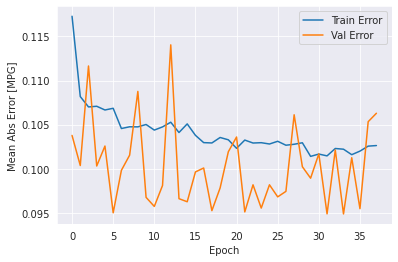

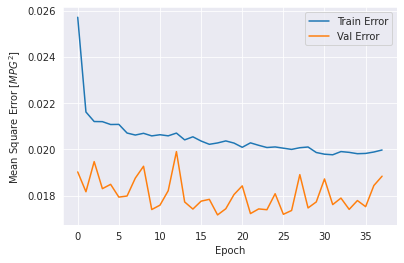

In [125]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

## Training by using Decision Tree

In [126]:
from sklearn import tree

In [127]:
tree_clf = tree.DecisionTreeRegressor()
tree_clf.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

## Training by using Regression

In [138]:
tscv = TimeSeriesSplit(n_splits=3)
model1 = XGBRegressor()

param_grid = {'nthread':[4,6,8], 
              'objective':['reg:squarederror'],
              'learning_rate':[.03, 0.05, .07],
              'max_depth':[5, 6, 7],
              'min_child_weight':[4],
              'subsample':[0.7],
              'colsample_bytree':[0.7],
              'n_estimators':[500]}

GridSearch=GridSearchCV(estimator=model1,param_grid=param_grid,cv=tscv,n_jobs=4, verbose=10)
GridSearch.fit(X_train,y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   25.8s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  5.8min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  6.7min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  9.8min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 10.8min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 16.7min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 19.4min
[Parallel(n_jobs=4)]: Done  81 out of  81 | elapsed: 22.1min finished
/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:242: DeprecationWarning: The nthread parameter is deprecated as of version .6.Please use n_jobs instead.nthread is deprecated.
  'nthread is deprecated.', DeprecationWarning)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objectiv...
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid='deprecated', n_jobs=4,
             param_grid={'colsample_bytree': [0.7],
                         'learning_rate': [0.03, 0.05, 0.07],
                         'max_depth': [5, 6, 7], 'mi

## Training by using Ridge Regression

In [129]:
from sklearn import linear_model

reg = linear_model.Ridge(alpha=.5)
reg.fit(X_train, y_train)

Ridge(alpha=0.5, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

## Training by using Random forest

In [130]:
model2 = RandomForestRegressor()

param_grid2={'n_estimators':[10,50,100,1000],
             'max_features':[1, 2, 3]   
            }

GridSearch2=GridSearchCV(estimator=model2,param_grid=param_grid2,cv=tscv,n_jobs=10, verbose=10)
GridSearch2.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    3.1s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done  21 out of  36 | elapsed:    7.8s remaining:    5.6s
[Parallel(n_jobs=10)]: Done  25 out of  36 | elapsed:    9.5s remaining:    4.2s
[Parallel(n_jobs=10)]: Done  29 out of  36 | elapsed:   21.6s remaining:    5.2s
[Parallel(n_jobs=10)]: Done  33 out of  36 | elapsed:   31.1s remaining:    2.8s
[Parallel(n_jobs=10)]: Done  36 out of  36 | elapsed:   35.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbo

## Training by using SVM

In [131]:
model3 = svm.SVR()

param_grid3={'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]}

GridSearch3=GridSearchCV(estimator=model3,n_jobs=10, verbose=10, param_grid=param_grid3)
GridSearch3.fit(X_train,y_train, )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   15.0s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   24.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   35.6s
[Parallel(n_jobs=10)]: Done  26 out of  40 | elapsed:   43.0s remaining:   23.2s
[Parallel(n_jobs=10)]: Done  31 out of  40 | elapsed:   50.7s remaining:   14.7s
[Parallel(n_jobs=10)]: Done  36 out of  40 | elapsed:   54.0s remaining:    6.0s
[Parallel(n_jobs=10)]: Done  40 out of  40 | elapsed:   54.9s finished
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=10,
             param_grid={'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=10)

## Training by using Neural network

In [135]:
from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(max_iter=1000)
mlp_reg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1342: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# Evaluation

In [132]:
y_pred = model.predict(X_test)
# print(scaler.inverse_transform(y_pred))
# print(scaler.inverse_transform(y_test))


In [139]:
y_pred2 = GridSearch.predict(X_test)
y_pred3 = GridSearch2.predict(X_test)
y_pred4 = GridSearch3.predict(X_test)
y_pred5 = tree_clf.predict(X_test)
y_pred6 = reg.predict(X_test)
y_pred7 = mlp_reg.predict(X_test)

In [140]:
MSE_DNN=mean_squared_error(y_pred,y_test)
MSE_rg=mean_squared_error(y_pred2,y_test)
MSE_rf=mean_squared_error(y_pred3,y_test)
MSE_tree=mean_squared_error(y_pred5,y_test)
MSE_svr=mean_squared_error(y_pred4,y_test)
MSE_ridge = mean_squared_error(y_pred6, y_test)
MSE_mlp = mean_squared_error(y_pred7, y_test)

print('MSE for XGBoost is '+str(MSE_rg))
print('MSE for RandomForest is '+str(MSE_rf))
print(f"MSE for dnn is: {MSE_DNN}")
print(f"MSE for decision is: {MSE_tree}")
print(f"MSE for svr is: {MSE_svr}")
print(f"MSE for ridge is: {MSE_ridge}")
print(f"MSE for neural network is: {MSE_mlp}")

MSE for XGBoost is 0.01726006344884727
MSE for RandomForest is 0.015177183077877169
MSE for dnn is: 0.021906888345540523
MSE for decision is: 0.025013354977883036
MSE for svr is: 0.020732502038850405
MSE for ridge is: 0.02317702945371461
MSE for neural network is: 0.02032315238540893
